# 04d - Vertex AI - AutoML for Global Forecasting with Deep Learning - multiple parallel scenarios


### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery
- 04b - Vertex AI - AutoML for Global Forecasting with Deep Learning - In GCP Console (no code)
- 04c - 04c - Vertex AI - AutoML for Global Forecasting with Deep Learning - with Python client (code)

### Overview:
- Setup
- Create Dataset
- Train Forecasting Model with AutoML - Multiple Scenarios
    - Function to Create AutoML Forecasting Jobs and Run Them
- Review Scenarios
    - Review Custom Metrics with SQL
    - Find Context Window Scenario with Best pMAE score (minimum)
    - Create BigQuery Table with Best Forecast For Each Series based on pMAE
- Results
    - Retrieve Test Data
    - Review Custom Metrics with SQL
    - Retrieve the Forecasting Data (raw series)
    - Visualize the Time Series with Forecast

### Resources:
- [Train an AutoML model (Vertex AI API)](https://cloud.google.com/vertex-ai/docs/training/automl-api#forecasting)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Optimization objectives for tabular AutoML models](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj#forecasting)
- [Evaluation metrics returned by Vertex AI](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models#evaluation_metrics_returned_by)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04d_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04d_console.png">

---
## Setup

inputs:

In [9]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04d'

packages:

In [10]:
from google.cloud import bigquery
from google.cloud import aiplatform

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [11]:
bigquery = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

---
## Create Dataset (Link to BigQuery Table)

Reference for [`aiplatform.TimeSeriesDataset.create`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.TimeSeriesDataset.create)

In [4]:
dataset = aiplatform.TimeSeriesDataset.create(
    display_name = f'{NOTEBOOK}_{DATANAME}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.datasets.dataset:Creating TimeSeriesDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TimeSeriesDataset backing LRO: projects/715288179162/locations/us-central1/datasets/4830308512447856640/operations/632839929004556288
INFO:google.cloud.aiplatform.datasets.dataset:TimeSeriesDataset created. Resource name: projects/715288179162/locations/us-central1/datasets/4830308512447856640
INFO:google.cloud.aiplatform.datasets.dataset:To use this TimeSeriesDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/4830308512447856640')


In [13]:
#dataset = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/4830308512447856640')

---
## Train Forecasting Model with AutoML - Multiple Scenarios

The goal here is to train a range of AutoML Forecasting Models on the same data using combination of forecast horizon and context window.  This is follow the guidance of [Considerations for setting the context window and forecast horizon](https://cloud.google.com/vertex-ai/docs/datasets/bp-tabular#context-window).

The test data reflects a forecast horizon of 16 days which we want to keep for comparion to methods in other notebooks.  This leaves us with the option to change the context window in order to select the best scenario.  The first step is to double the contect window. Looking ahead we discover this actually makes for worse forecast.  This is understandable because this example data has multiple time series that are recently introduced bike stations.  This is a case were a shorter context window is likely to gain more recent and relevant forecasting information.  For this reason we consider these context windows to compare:

- Context Window = 16 - Notebook 04b
- Context Window = 32 - Notebook 04c
- Context Window = 8
- Context Window = 4
- Context Window = 2
- Context Window = 1
- Context Window = 0

Note, there is a default concurrent training job limit for Vertex AI AutoML of 5 jobs ([reference here](https://cloud.google.com/vertex-ai/docs/quotas#tabular)).  Here we are running 5 jobs but it we needed to run more we would have to wait for a job to complete or submit a quota increas ([reference here](https://cloud.google.com/vertex-ai/docs/quotas#quota_increases)).

### Function to Create AutoML Forecasting Jobs and Run Them

Reference for [`aiplatform.AutoMLForecastingTrainingJob`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob)

Reference for [`aiplatform.AutoMLForecastingTrainingJob.run`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob.run)

In [21]:
def scenario(ds, cw):
    column_specs = list(set(dataset.column_names) - set(['splits','start_station_name']))
    column_specs = dict.fromkeys(column_specs, 'auto')
    
    forecast_job = aiplatform.AutoMLForecastingTrainingJob(
        display_name = f'{NOTEBOOK}_{DATANAME}_CW{cw}',
        optimization_objective = "minimize-rmse",
        column_specs = column_specs,
        labels = {'notebook':f'{NOTEBOOK}', 'cw':f'{cw}'}
    )
    
    forecast = forecast_job.run(
        dataset = ds,
        target_column = "num_trips",
        time_column = "date",
        time_series_identifier_column = "start_station_name",
        unavailable_at_forecast_columns = ["num_trips",],
        available_at_forecast_columns = ["date",],
        forecast_horizon = 16,
        data_granularity_unit = "day",
        data_granularity_count = 1,
        predefined_split_column_name = "splits",
        context_window = cw,
        export_evaluated_data_items = True,
        export_evaluated_data_items_bigquery_destination_uri = f"bq://{PROJECT_ID}:{DATANAME}:{NOTEBOOK}_automl_cw{cw}",
        validation_options = "fail-pipeline",
        budget_milli_node_hours = 1000,
        model_display_name = f"{NOTEBOOK}_{DATANAME}_CW{cw}",
        model_labels = {'notebook':f'{NOTEBOOK}', 'cw':f'{cw}'},
        sync = False
    )
    
    return forecast

In [22]:
windows = [8, 4, 2, 1, 0]

In [23]:
scenarios = []
for w in windows:
    scenarios.append(scenario(dataset, w))

INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2069897159741800448?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/866310159327035392?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/6681583178169188352?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8609123818683760640?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8960404589618659328?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPi

<img src="architectures/notebooks/04d_screenshots/train_1.png">

---
## Review Scenarios

### Review Custom Metrics with SQL
Compare results by series for each context window scenario in this notebook combined with `04b` and `04d`

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [54]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predited_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_best`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predited_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.596133,41.371184,0.266911
1,Central Park S & 6 Ave,forecast,0.362407,70.573327,0.212891
2,Central Park W & W 96 St,forecast,0.527306,20.625376,0.208997
3,Central Park West & W 100 St,forecast,0.833055,13.649379,0.331396
4,Central Park West & W 102 St,forecast,0.408166,10.880742,0.210002
5,Central Park West & W 68 St,forecast,0.340426,35.659350,0.233354
6,Central Park West & W 72 St,forecast,0.457076,43.527208,0.239160
7,Central Park West & W 76 St,forecast,0.329753,24.140621,0.216387
8,Central Park West & W 85 St,forecast,0.859761,39.604630,0.322864
9,Grand Army Plaza & Central Park S,forecast,0.394569,42.012672,0.187612


### Find Context Window Scenario with Best pMAE score (minimum)

In [33]:
bestCW = customMetrics[customMetrics['pMAE'] == customMetrics.groupby(['start_station_name'])['pMAE'].transform('min')].reset_index()
bestCW

,index,start_station_name,CW,time_series_type,MAPE,MAE,pMAE
0,1,Central Park North & Adam Clayton Powell Blvd,1,forecast,0.596133,41.371184,0.266911
1,10,Central Park S & 6 Ave,2,forecast,0.362407,70.573327,0.212891
2,16,Central Park W & W 96 St,16,forecast,0.527306,20.625376,0.208997
3,27,Central Park West & W 100 St,8,forecast,0.833055,13.649379,0.331396
4,33,Central Park West & W 102 St,4,forecast,0.408166,10.880742,0.210002
5,35,Central Park West & W 68 St,0,forecast,0.340426,35.659350,0.233354
6,47,Central Park West & W 72 St,4,forecast,0.457076,43.527208,0.239160
7,53,Central Park West & W 76 St,32,forecast,0.329753,24.140621,0.216387
8,56,Central Park West & W 85 St,0,forecast,0.859761,39.604630,0.322864
9,68,Grand Army Plaza & Central Park S,4,forecast,0.394569,42.012672,0.187612


### Create BigQuery Table with Best Forecast For Each Series based on pMAE

In [36]:
tableMap = {
    '0' : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw0',
    '1' : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw1',
    '2' : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw2',
    '4' : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw4',
    '8' : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw8',
    '16' : f'{PROJECT_ID}.{DATANAME}.04b_automl',
    '32' : f'{PROJECT_ID}.{DATANAME}.04c_automl',
}

In [51]:
query = """"""
for i, row in bestCW.iterrows():
    if i> 0: query += f"""UNION ALL
    """
    query += f"""SELECT *, '{row['CW']}' as CW FROM `{tableMap[row['CW']]}` WHERE start_station_name = '{row['start_station_name']}'
    """
    
query = f"""CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_best` AS
""" + query + """ORDER BY start_station_name, date
"""
print(query)

CREATE OR REPLACE TABLE `statmike-demo3.citibikes.04d_automl_best` AS
SELECT *, '1' as CW FROM `statmike-demo3.citibikes.04d_automl_cw1` WHERE start_station_name = 'Central Park North & Adam Clayton Powell Blvd'
    UNION ALL
    SELECT *, '2' as CW FROM `statmike-demo3.citibikes.04d_automl_cw2` WHERE start_station_name = 'Central Park S & 6 Ave'
    UNION ALL
    SELECT *, '16' as CW FROM `statmike-demo3.citibikes.04b_automl` WHERE start_station_name = 'Central Park W & W 96 St'
    UNION ALL
    SELECT *, '8' as CW FROM `statmike-demo3.citibikes.04d_automl_cw8` WHERE start_station_name = 'Central Park West & W 100 St'
    UNION ALL
    SELECT *, '4' as CW FROM `statmike-demo3.citibikes.04d_automl_cw4` WHERE start_station_name = 'Central Park West & W 102 St'
    UNION ALL
    SELECT *, '0' as CW FROM `statmike-demo3.citibikes.04d_automl_cw0` WHERE start_station_name = 'Central Park West & W 68 St'
    UNION ALL
    SELECT *, '4' as CW FROM `statmike-demo3.citibikes.04d_automl_cw4` WH

In [52]:
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

1.67

---
## Results

### Retrieve Test Data (best context window prepared above)

In [53]:
query = f"""
WITH
    RAW AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predited_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_best`
    ),
    LEAD AS (
        SELECT *, DATE_DIFF(date, predited_on_date, DAY) as prediction_lead_days
        FROM RAW
    ),
    LEFTSIDE AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD
        GROUP BY start_station_name, date
    )
SELECT *
FROM LEFTSIDE
LEFT OUTER JOIN LEAD
USING (start_station_name, date, prediction_lead_days)
"""
autoML = bigquery.query(query = query).to_dataframe()
autoML

,start_station_name,date,prediction_lead_days,predited_on_date,num_trips,splits,predicted_num_trips
0,Central Park North & Adam Clayton Powell Blvd,2016-09-15,0,2016-09-15,132,TEST,129.253647
1,Central Park North & Adam Clayton Powell Blvd,2016-09-16,0,2016-09-16,175,TEST,130.479523
2,Central Park North & Adam Clayton Powell Blvd,2016-09-17,0,2016-09-17,269,TEST,249.340500
3,Central Park North & Adam Clayton Powell Blvd,2016-09-18,0,2016-09-18,272,TEST,291.095184
4,Central Park North & Adam Clayton Powell Blvd,2016-09-19,0,2016-09-19,39,TEST,222.466263
...,...,...,...,...,...,...,...
178,W 82 St & Central Park West,2016-09-26,0,2016-09-26,102,TEST,85.013084
179,W 82 St & Central Park West,2016-09-27,0,2016-09-27,105,TEST,79.466576
180,W 82 St & Central Park West,2016-09-28,0,2016-09-28,72,TEST,80.653526
181,W 82 St & Central Park West,2016-09-29,0,2016-09-29,143,TEST,75.377708


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [54]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predited_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_best`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predited_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.596133,41.371184,0.266911
1,Central Park S & 6 Ave,forecast,0.362407,70.573327,0.212891
2,Central Park W & W 96 St,forecast,0.527306,20.625376,0.208997
3,Central Park West & W 100 St,forecast,0.833055,13.649379,0.331396
4,Central Park West & W 102 St,forecast,0.408166,10.880742,0.210002
5,Central Park West & W 68 St,forecast,0.340426,35.659350,0.233354
6,Central Park West & W 72 St,forecast,0.457076,43.527208,0.239160
7,Central Park West & W 76 St,forecast,0.329753,24.140621,0.216387
8,Central Park West & W 85 St,forecast,0.859761,39.604630,0.322864
9,Grand Army Plaza & Central Park S,forecast,0.394569,42.012672,0.187612


### Retrieve the Forecasting Data (raw series)

In [55]:
query = f"""
SELECT start_station_name, date, splits, num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [56]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-08-31,2016-09-15,2016-09-30,16


### Visualize The Time Series with Forecast

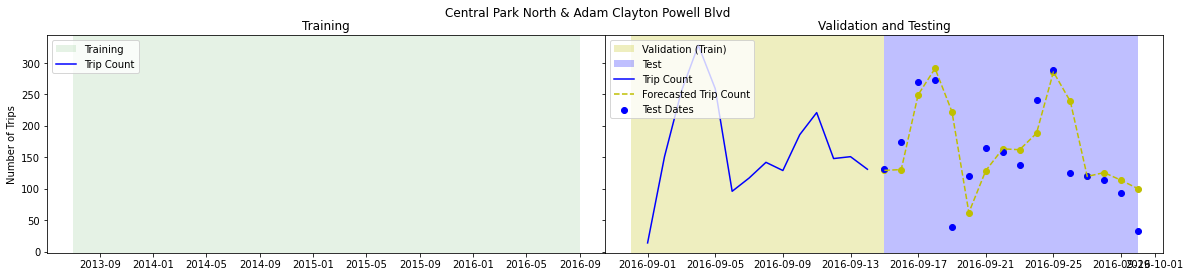

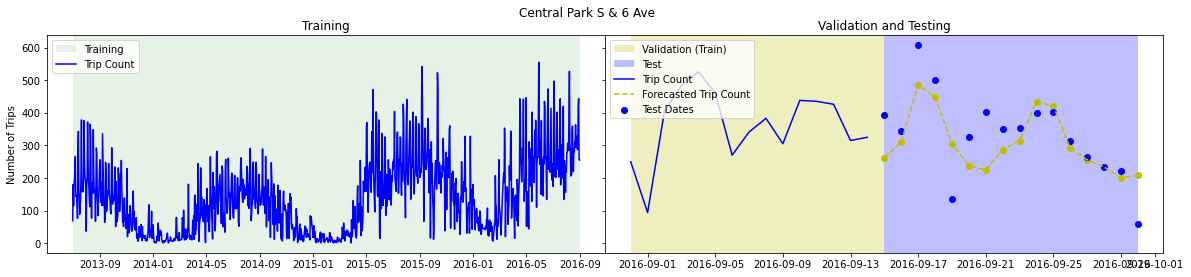

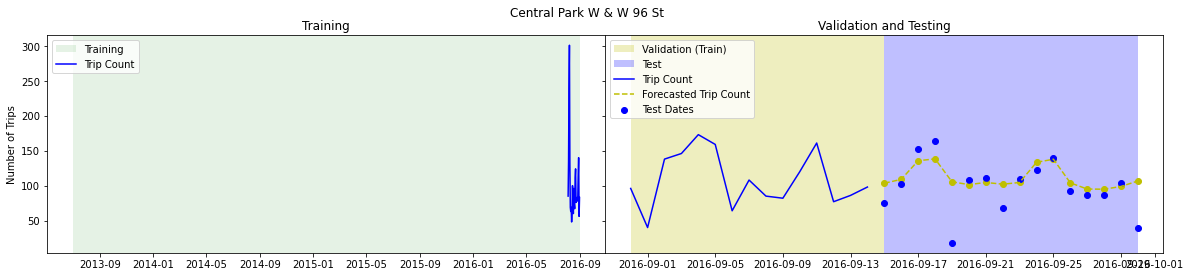

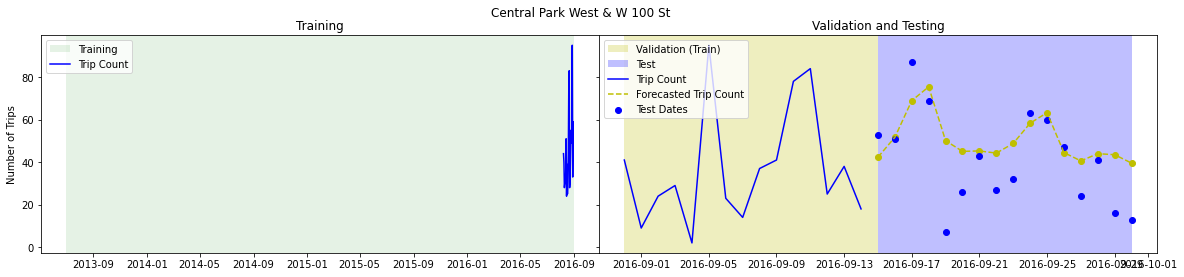

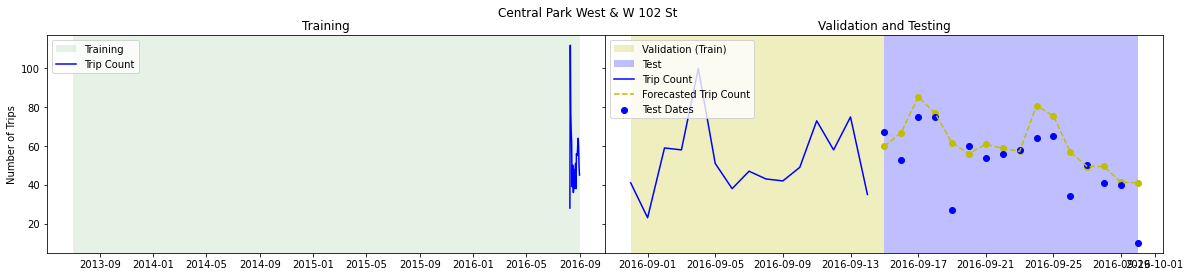

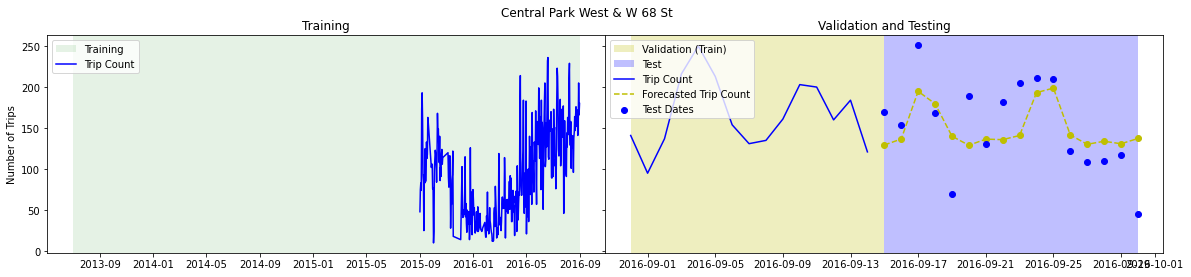

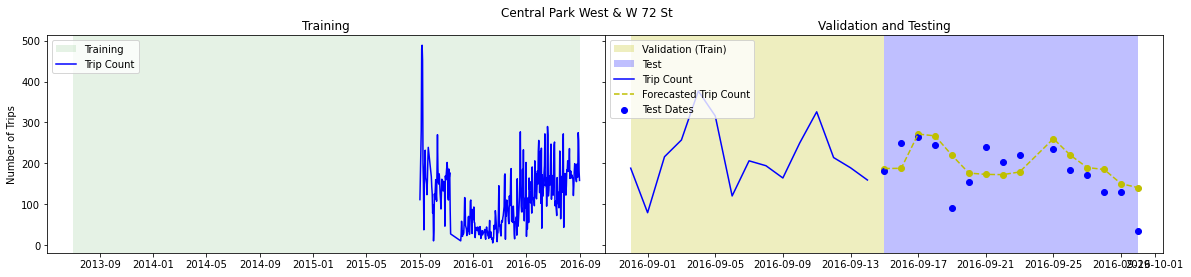

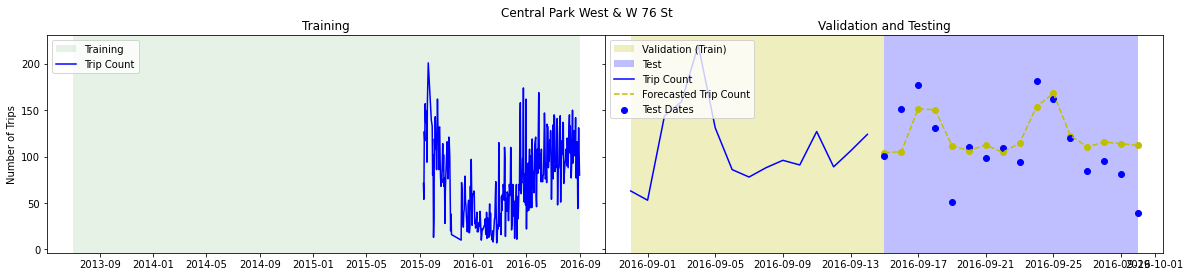

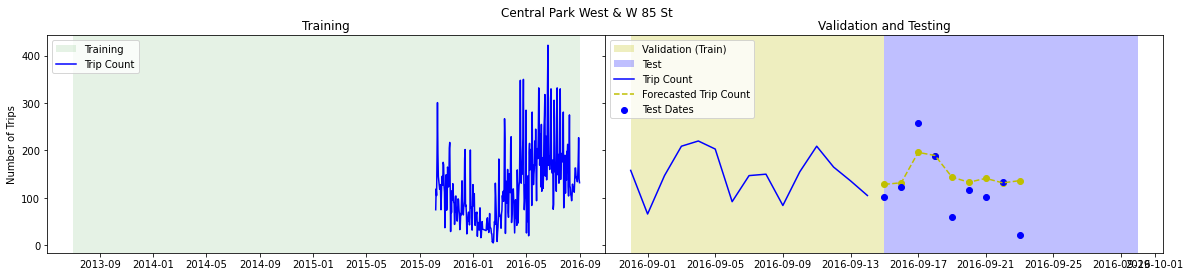

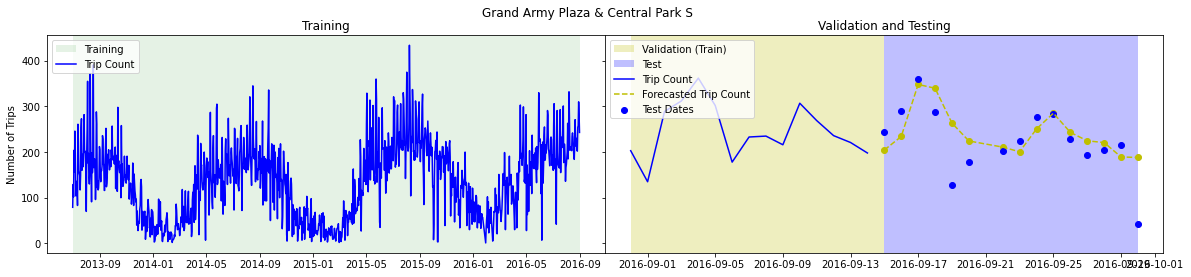

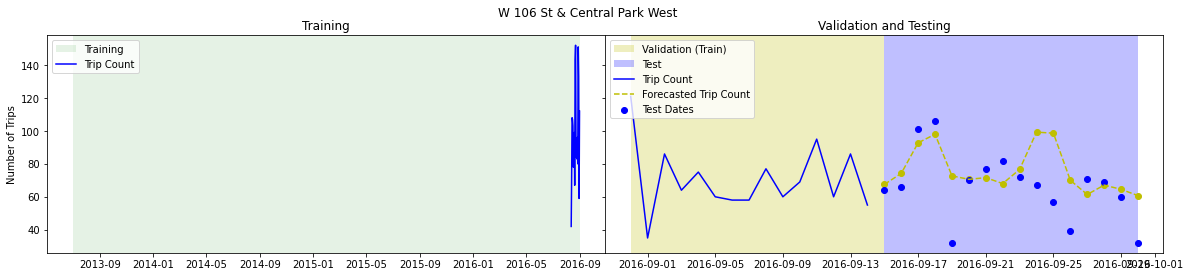

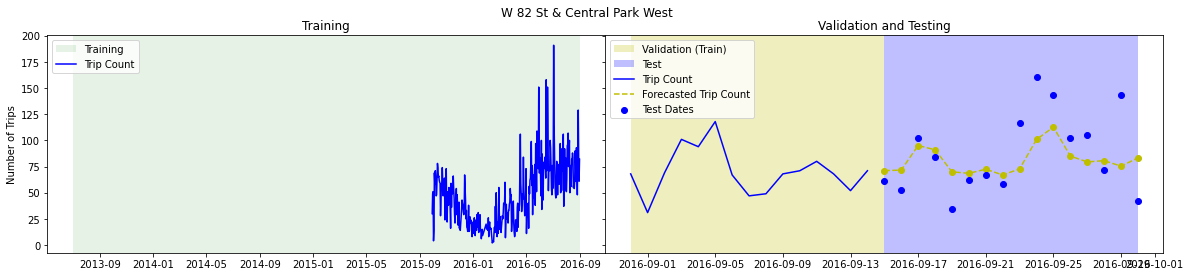

In [57]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    #axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    axes[1].plot(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].scatter(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y')
    
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"